# Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language. 

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user. 

And, it will return an output that adheres to the tool's schema. 

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 
 
You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Let's showcase a simple example of tool calling!
 
The `multiply` function is our tool.

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [4]:
def multiply_tool(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply_tool])

If we pass an input - e.g., `"What is 2 multiplied by 3"` - we see a tool call returned. 

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [5]:
from langchain_core.messages import HumanMessage

result = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [6]:
result.content

''

In [7]:
result.tool_calls

[{'name': 'multiply_tool',
  'args': {'a': 2, 'b': 3},
  'id': 'call_Gs2q7nCyl02LJ3lUNnmARRX2',
  'type': 'tool_call'}]

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

## Graph with tool calling llm

Now, lets use `MessagesState` with a graph.

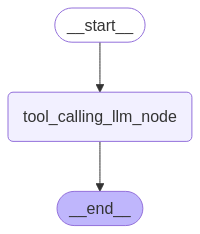

In [8]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState


# Node
def tool_calling_llm_node(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm_node", tool_calling_llm_node)

builder.add_edge(START, "tool_calling_llm_node")
builder.add_edge("tool_calling_llm_node", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [9]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! How can I assist you today?


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [10]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply_tool (call_UEW1TtEk7J6x7jRhKy8TwTLs)
 Call ID: call_UEW1TtEk7J6x7jRhKy8TwTLs
  Args:
    a: 2
    b: 3


### Let's add a tool node to execute the llm tool request:

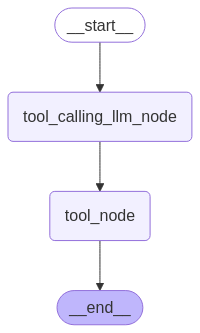

In [11]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode


# Node
def tool_calling_llm_node(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm_node", tool_calling_llm_node)
builder.add_node("tool_node", ToolNode([multiply_tool]))

builder.add_edge(START, "tool_calling_llm_node")
builder.add_edge("tool_calling_llm_node", "tool_node")
builder.add_edge("tool_node", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply_tool (call_L5pFeP8KR0cWdUwkdzLFlcPk)
 Call ID: call_L5pFeP8KR0cWdUwkdzLFlcPk
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply_tool

6


In [13]:
# Q: what is the initial question didn't have a request for tool call?
# For example, it was "What is the capital of Cyprus?"

## Ok, let's add more tools!

In [14]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")

# For this ipynb we set parallel tool calling to false as math generally is done sequentially, 
# and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, 
# see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

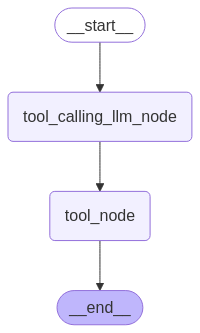

In [15]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode


# Node
def tool_calling_llm_node(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm_node", tool_calling_llm_node)
builder.add_node("tool_node", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm_node")
builder.add_edge("tool_calling_llm_node", "tool_node")
builder.add_edge("tool_node", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_DVa4TmyW8whIcgvHVIYaxsh6)
 Call ID: call_DVa4TmyW8whIcgvHVIYaxsh6
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [17]:
messages = graph.invoke({"messages": HumanMessage(content="Devide 6 by 2")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Devide 6 by 2
================================== Ai Message ==================================
Tool Calls:
  divide (call_I3rwT2hi6Bhl6fbPZLs32j97)
 Call ID: call_I3rwT2hi6Bhl6fbPZLs32j97
  Args:
    a: 6
    b: 2
================================= Tool Message =================================
Name: divide

3.0


# Explicit `__end__` call

Alright, if our tool node does not receive a tool as input, it simply passes the execution graph through itself without modifying the graph’s state.

For the next block, we need to learn how to more explicitly transition the graph to a final state if the tool node no longer needs to be invoked.

# Such graph we'll call a "router"

* Our chat model will decide to make a tool call or not based upon the user input
* We use a conditional edge to route to a node that will call our tool or simply end

![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)


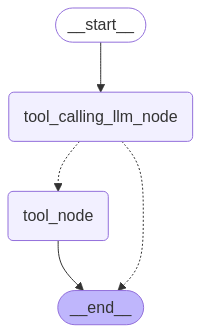

In [26]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from typing import Annotated, Literal

# Node
def tool_calling_llm_node(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

def router_edge(state: MessagesState):
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tool_node"
    return END

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm_node", tool_calling_llm_node)
builder.add_node("tool_node", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm_node")
builder.add_conditional_edges(
    "tool_calling_llm_node",
    router_edge,
)
builder.add_edge("tool_node", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
messages = graph.invoke({"messages": HumanMessage(content="Devide 6 by 2")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Devide 6 by 2
================================== Ai Message ==================================
Tool Calls:
  divide (call_ZeI8kai9HmQlCQj37kh8Ia7A)
 Call ID: call_ZeI8kai9HmQlCQj37kh8Ia7A
  Args:
    a: 6
    b: 2
================================= Tool Message =================================
Name: divide

3.0


## ReAct agent


Now, we can extend this into a generic agent architecture.

In the above router, we invoked the model and, if it chose to call a tool, we returned a `ToolMessage` to the user.
 
But, what if we simply pass that `ToolMessage` *back to the model*?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind [ReAct](https://react-lm.github.io/), a general agent architecture.
  
* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

This [general purpose architecture](https://blog.langchain.dev/planning-for-agents/) can be applied to many types of tools. 

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

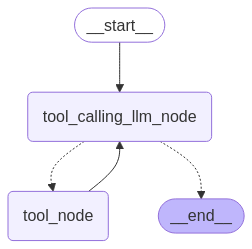

In [29]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from typing import Annotated, Literal

# Node
def tool_calling_llm_node(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

def router_edge(state: MessagesState):
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tool_node"
    return END

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm_node", tool_calling_llm_node)
builder.add_node("tool_node", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm_node")
builder.add_conditional_edges(
    "tool_calling_llm_node",
    router_edge,
)
builder.add_edge("tool_node", "tool_calling_llm_node")
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 7")]
messages = graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 7
================================== Ai Message ==================================
Tool Calls:
  add (call_zBAOKxcM6NHGJSgDwLe1zSup)
 Call ID: call_zBAOKxcM6NHGJSgDwLe1zSup
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_vytYPYnaoLNzWqCVdGi4U8wg)
 Call ID: call_vytYPYnaoLNzWqCVdGi4U8wg
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_R1gG9xMVBylVWE2VJJSIa1ys)
 Call ID: call_R1gG9xMVBylVWE2VJJSIa1ys
  Args:
    a: 14
    b: 7
================================= Tool Message ===============